In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree, shortest_path
from scipy.interpolate import splprep, splev

# =========================
# 1. Load data
# =========================
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH)
areas = np.load(AREAS_PATH, allow_pickle=True)

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]  # shape (Nstim,)

In [3]:
print(R.shape)

(39209, 118)


In [5]:
# R: neurons × stimuli
# vit_pc1: stimuli

# Normalize vit_pc1 for safety
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# Compute correlations
# Vectorized: corr(n_i, v) for all neurons
R_centered = R - R.mean(axis=1, keepdims=True)
R_std = R.std(axis=1, keepdims=True) + 1e-8

corr = (R_centered @ v) / (R_std[:, 0] * (len(v)-1))


order = np.argsort(-corr)  # descending correlation
R_sorted = R[order]
areas_sorted = areas[order]
corr_sorted = corr[order]

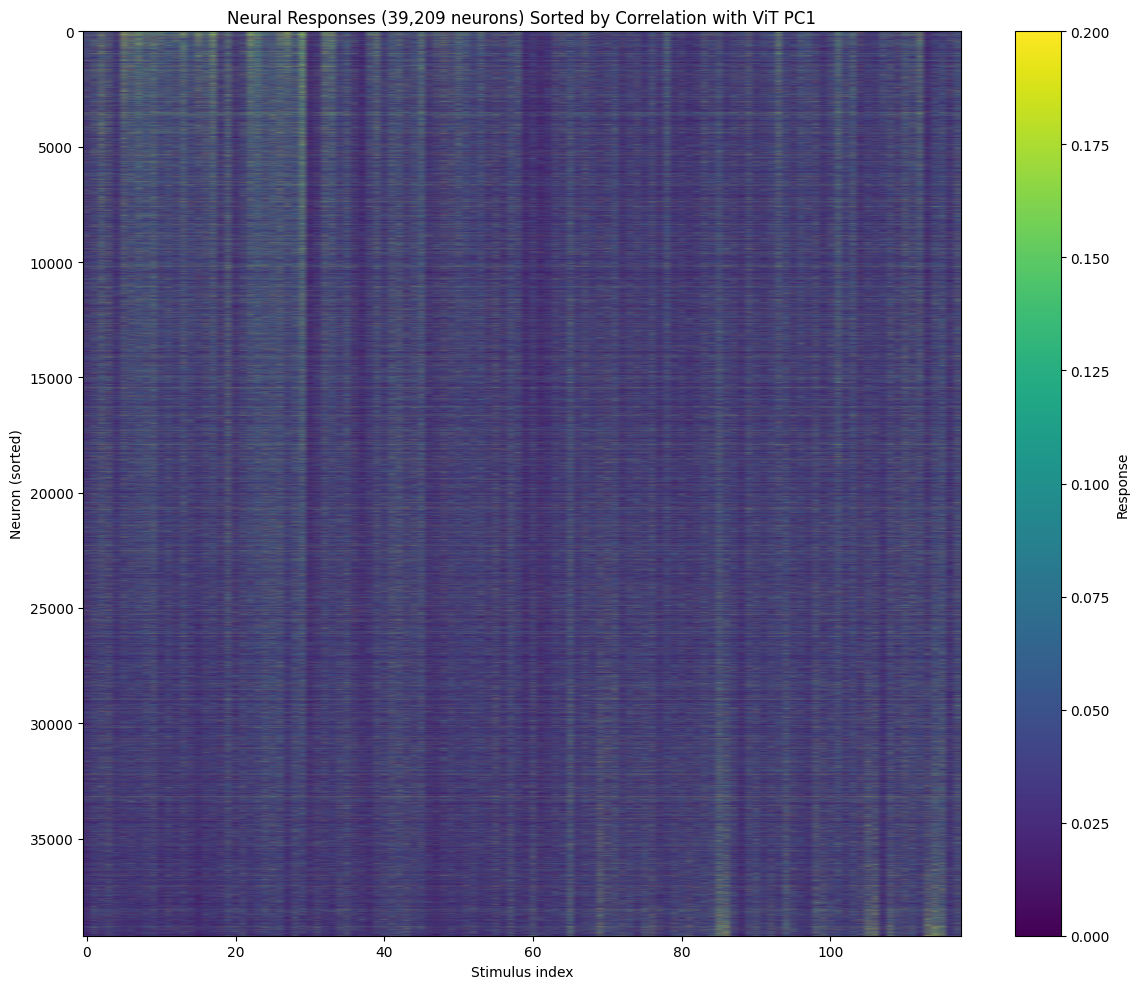

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(R_sorted, aspect='auto', cmap='viridis', vmin=0, vmax=0.2)
plt.colorbar(label='Response')
plt.title("Neural Responses (39,209 neurons) Sorted by Correlation with ViT PC1")
plt.xlabel("Stimulus index")
plt.ylabel("Neuron (sorted)")
plt.tight_layout()
plt.show()

[0.08 0.06 0.12 0.14 0.1  0.54 0.48 0.3  0.18 0.32 0.04 0.14 0.12 0.46
 0.16 0.16 0.16 0.16 0.24 0.1  0.1  0.04 0.54 0.26 0.04 0.02 0.08 0.22
 0.08 0.16 0.04 0.06 0.14 0.7  0.18 0.14 0.04 0.18 0.18 0.18 0.14 0.26
 0.04 0.06 0.14 0.26 0.08 0.26 0.24 0.02 0.64 0.16 0.26 0.06 0.04 0.1
 0.12 0.5  0.02 0.22 0.   0.04 0.02 0.1  0.04 0.14 0.2  0.04 0.12 0.04
 0.1  0.04 0.14 0.08 0.06 0.02 0.06 0.06 0.1  0.04 0.1  0.08 0.06 0.06
 0.1  0.12 0.   0.02 0.04 0.06 0.1  0.06 0.06 0.42 0.04 0.06 0.14 0.02
 0.08 0.   0.08 0.04 0.14 0.1  0.14 0.04 0.04 0.06 0.14 0.32 0.08 0.08
 0.1  0.02 0.04 0.1  0.12 0.06]


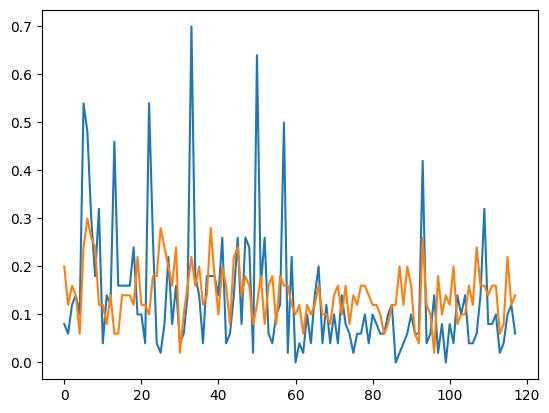

In [9]:
print(R_sorted[0])
plt.plot(R_sorted[0])
plt.plot(R_sorted[1])

[0.08 0.06 0.12 0.14 0.1  0.54 0.48 0.3  0.18 0.32 0.04 0.14 0.12 0.46
 0.16 0.16 0.16 0.16 0.24 0.1  0.1  0.04 0.54 0.26 0.04 0.02 0.08 0.22
 0.08 0.16 0.04 0.06 0.14 0.7  0.18 0.14 0.04 0.18 0.18 0.18 0.14 0.26
 0.04 0.06 0.14 0.26 0.08 0.26 0.24 0.02 0.64 0.16 0.26 0.06 0.04 0.1
 0.12 0.5  0.02 0.22 0.   0.04 0.02 0.1  0.04 0.14 0.2  0.04 0.12 0.04
 0.1  0.04 0.14 0.08 0.06 0.02 0.06 0.06 0.1  0.04 0.1  0.08 0.06 0.06
 0.1  0.12 0.   0.02 0.04 0.06 0.1  0.06 0.06 0.42 0.04 0.06 0.14 0.02
 0.08 0.   0.08 0.04 0.14 0.1  0.14 0.04 0.04 0.06 0.14 0.32 0.08 0.08
 0.1  0.02 0.04 0.1  0.12 0.06]


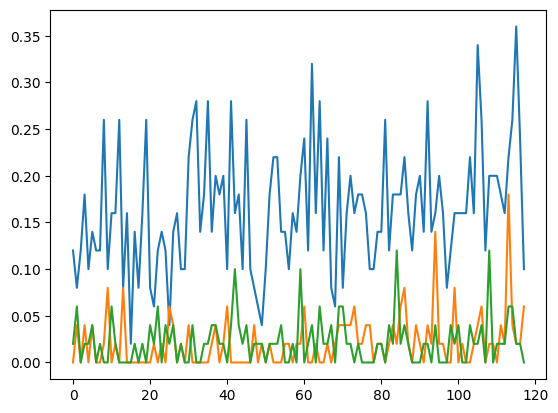

In [11]:
print(R_sorted[0])
plt.plot(R_sorted[-1])
plt.plot(R_sorted[-2])
plt.plot(R_sorted[-3])


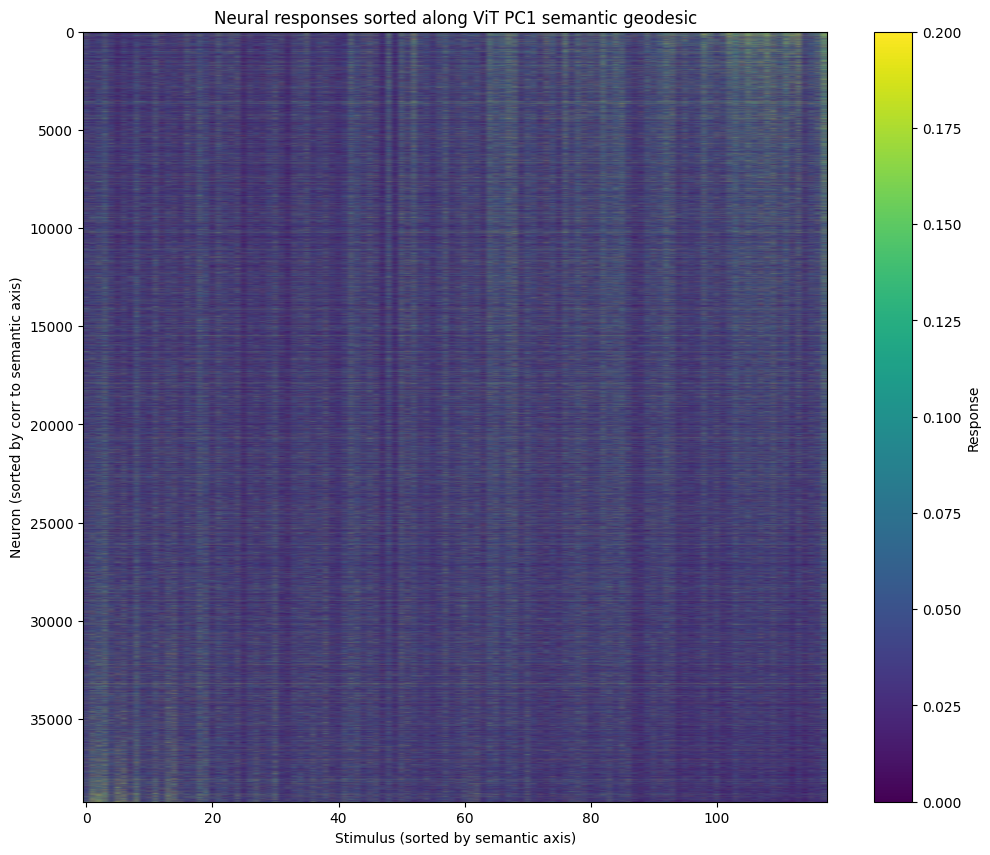

In [13]:
# R: neurons × stimuli
# vit_pc1: length = stimuli

# --- Normalize ViT PC1 ---
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# --- Correlation with ViT PC1 for each neuron ---
R_centered = R - R.mean(axis=1, keepdims=True)
R_std = R.std(axis=1, keepdims=True) + 1e-8

corr = (R_centered @ v) / (R_std[:, 0] * (len(v) - 1))

# --- Sort neurons by correlation (descending) ---
order_neurons = np.argsort(-corr)  
R_sorted_neurons = R[order_neurons]

areas_sorted = areas[order_neurons]
corr_sorted = corr[order_neurons]

# --- Sort stimuli by ViT PC1 (ascending semantic axis) ---
order_stimuli = np.argsort(v)  

# Apply column reordering
R_sorted_both = R_sorted_neurons[:, order_stimuli]

# For completeness:
vit_pc1_sorted = vit_pc1[order_stimuli]
v_sorted = v[order_stimuli]

plt.figure(figsize=(12,10))
plt.imshow(R_sorted_both, aspect="auto", cmap="viridis", vmax=0.2, vmin=0)
plt.colorbar(label="Response")
plt.xlabel("Stimulus (sorted by semantic axis)")
plt.ylabel("Neuron (sorted by corr to semantic axis)")
plt.title("Neural responses sorted along ViT PC1 semantic geodesic")
plt.show()


[0.1  0.   0.04 0.12 0.1  0.02 0.04 0.08 0.1  0.06 0.04 0.14 0.14 0.04
 0.04 0.14 0.06 0.06 0.14 0.04 0.1  0.08 0.08 0.04 0.06 0.04 0.1  0.
 0.06 0.12 0.08 0.12 0.04 0.02 0.08 0.04 0.   0.14 0.1  0.06 0.02 0.02
 0.04 0.04 0.1  0.06 0.32 0.18 0.1  0.22 0.08 0.1  0.1  0.2  0.26 0.1
 0.14 0.26 0.06 0.06 0.06 0.06 0.06 0.04 0.04 0.04 0.1  0.08 0.1  0.04
 0.5  0.14 0.24 0.24 0.16 0.12 0.42 0.04 0.08 0.14 0.02 0.02 0.26 0.14
 0.18 0.02 0.18 0.08 0.04 0.06 0.14 0.14 0.32 0.18 0.26 0.12 0.06 0.02
 0.46 0.04 0.06 0.18 0.22 0.26 0.48 0.54 0.7  0.14 0.16 0.12 0.16 0.3
 0.16 0.54 0.08 0.16 0.64 0.16]


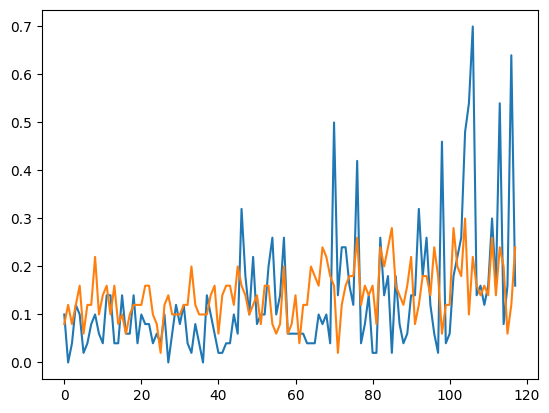

In [14]:
print(R_sorted_both[0])
plt.plot(R_sorted_both[0])
plt.plot(R_sorted_both[1])

[0.08 0.06 0.12 0.14 0.1  0.54 0.48 0.3  0.18 0.32 0.04 0.14 0.12 0.46
 0.16 0.16 0.16 0.16 0.24 0.1  0.1  0.04 0.54 0.26 0.04 0.02 0.08 0.22
 0.08 0.16 0.04 0.06 0.14 0.7  0.18 0.14 0.04 0.18 0.18 0.18 0.14 0.26
 0.04 0.06 0.14 0.26 0.08 0.26 0.24 0.02 0.64 0.16 0.26 0.06 0.04 0.1
 0.12 0.5  0.02 0.22 0.   0.04 0.02 0.1  0.04 0.14 0.2  0.04 0.12 0.04
 0.1  0.04 0.14 0.08 0.06 0.02 0.06 0.06 0.1  0.04 0.1  0.08 0.06 0.06
 0.1  0.12 0.   0.02 0.04 0.06 0.1  0.06 0.06 0.42 0.04 0.06 0.14 0.02
 0.08 0.   0.08 0.04 0.14 0.1  0.14 0.04 0.04 0.06 0.14 0.32 0.08 0.08
 0.1  0.02 0.04 0.1  0.12 0.06]


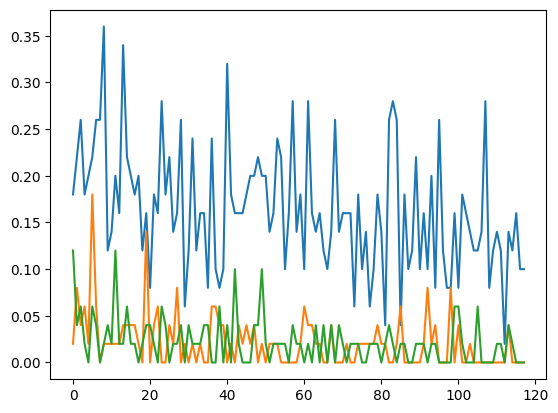

In [15]:
print(R_sorted[0])
plt.plot(R_sorted_both[-1])
plt.plot(R_sorted_both[-2])
plt.plot(R_sorted_both[-3])

In [ ]:
plt.figure(figsize=(10, 50), dpi=400)
plt.imshow(R_sorted_both, aspect='auto', cmap='viridis', interpolation='bilinear', vmin=0, vmax=0.2)


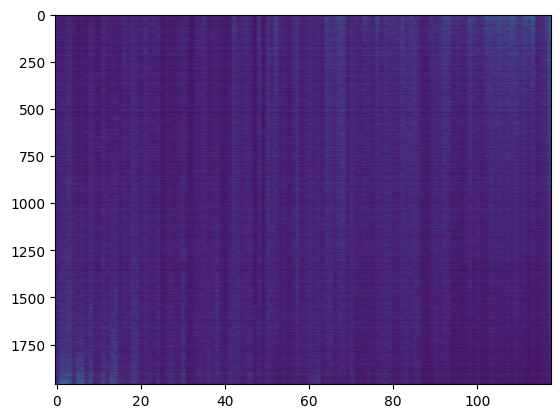

In [18]:
bin_size = 20
n, m = R_sorted_both.shape

# Amount needed to reach next multiple
pad = (bin_size - (n % bin_size)) % bin_size

R_pad = np.pad(R_sorted_both, ((0, pad), (0, 0)), mode='constant', constant_values=0)

R_down = R_pad.reshape(-1, bin_size, m).mean(axis=1)

plt.imshow(R_down, aspect='auto', cmap='viridis')
plt.show()
